In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [3]:
class NPZChessDataset(Dataset):
    def __init__(self, npz_path: Path):
        with np.load(npz_path) as data:
            self.X = torch.tensor(data["X"], dtype=torch.float32) # float32 for NNs
            self.y = torch.tensor(data["y"], dtype=torch.long) # long for CrossEntropyLoss

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        return self.X[idx], self.y[idx]

In [4]:
BATCH_SIZE = 2048
num_workers = 0

train_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed/chess_state_bitboard_train.npz"), 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)
val_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed/chess_state_bitboard_val.npz"), 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)
test_dataloader = DataLoader(dataset=NPZChessDataset("./dataset_processed/chess_state_bitboard_test.npz"), 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [5]:
import time

start = time.time()
for i, (X, y) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.01967628240585327


In [6]:
Xb, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype, "classes in batch:", yb.unique().tolist())

X batch shape: torch.Size([2048, 774]) dtype: torch.float32
y batch shape: torch.Size([2048]) dtype: torch.int64 classes in batch: [0, 1, 2, 3, 4, 5, 6]


In [7]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [8]:
class GiraffeBaselineWithDropout(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.network(x)

In [9]:
from torchinfo import summary

model = GiraffeBaselineWithDropout(input_shape=774,
                        hidden_units=2048,
                        output_shape=7) # 7 classes

summary(model, input_size=(32, 774))

Layer (type:depth-idx)                   Output Shape              Param #
GiraffeBaselineWithDropout               [32, 7]                   --
├─Sequential: 1-1                        [32, 7]                   --
│    └─Linear: 2-1                       [32, 2048]                1,587,200
│    └─ReLU: 2-2                         [32, 2048]                --
│    └─Dropout: 2-3                      [32, 2048]                --
│    └─Linear: 2-4                       [32, 2048]                4,196,352
│    └─ReLU: 2-5                         [32, 2048]                --
│    └─Dropout: 2-6                      [32, 2048]                --
│    └─Linear: 2-7                       [32, 7]                   14,343
Total params: 5,797,895
Trainable params: 5,797,895
Non-trainable params: 0
Total mult-adds (M): 185.53
Input size (MB): 0.10
Forward/backward pass size (MB): 1.05
Params size (MB): 23.19
Estimated Total Size (MB): 24.34

In [10]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [11]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """

    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [12]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   epochs: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_loss = float("inf")
    best_model_weights = None
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            print(f"Epoch {epoch}: New Best Val Loss: {val_loss:.4f} (Saved)")
            torch.save(model.state_dict(), f"{model_save_name}.pth")
        else:
            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            
        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train Acc: {train_acc} | Val Loss: {val_loss} | Val Acc: {val_acc}")

        # To plot results later
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Loss: {best_val_loss:.4f}")

    return results

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = GiraffeBaselineWithDropout(input_shape=774,
                                   hidden_units=2048,
                                   output_shape=7).to(device)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

result = run_experiment(model=model,
                        model_save_name="giraffe_baseline_with_dropout_with_state",
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device)

  1%|          | 1/100 [00:12<20:56, 12.69s/it]

Epoch 0: New Best Val Loss: 0.8301 (Saved)
Epoch: 0 | Train Loss: 1.0347669671868425 | Train Acc: 0.618137587915601 | Val Loss: 0.8300634659066493 | Val Acc: 0.6850563375409127


  2%|▏         | 2/100 [00:25<20:49, 12.75s/it]

Epoch 1: New Best Val Loss: 0.6699 (Saved)
Epoch: 1 | Train Loss: 0.7870917699830916 | Train Acc: 0.6995551770300512 | Val Loss: 0.6699026081026817 | Val Acc: 0.7485127821765498


  3%|▎         | 3/100 [00:38<20:30, 12.69s/it]

Epoch 2: New Best Val Loss: 0.5887 (Saved)
Epoch: 2 | Train Loss: 0.6701609396263767 | Train Acc: 0.7443376858216113 | Val Loss: 0.5886545886798781 | Val Acc: 0.7801555505751829


  4%|▍         | 4/100 [00:50<20:25, 12.77s/it]

Epoch 3: New Best Val Loss: 0.5434 (Saved)
Epoch: 3 | Train Loss: 0.5989501145489685 | Train Acc: 0.7725106397858057 | Val Loss: 0.5434379912152583 | Val Acc: 0.7951824671495956


  5%|▌         | 5/100 [01:03<20:12, 12.76s/it]

Epoch 4: New Best Val Loss: 0.5063 (Saved)
Epoch: 4 | Train Loss: 0.5490377996583728 | Train Acc: 0.792236203244885 | Val Loss: 0.506348517476296 | Val Acc: 0.8132146542284366


  6%|▌         | 6/100 [01:16<20:02, 12.79s/it]

Epoch 5: New Best Val Loss: 0.4836 (Saved)
Epoch: 5 | Train Loss: 0.5118710081595594 | Train Acc: 0.8058588754795396 | Val Loss: 0.4835762053119893 | Val Acc: 0.8210228298276858


  7%|▋         | 7/100 [01:29<19:54, 12.84s/it]

Epoch 6: New Best Val Loss: 0.4654 (Saved)
Epoch: 6 | Train Loss: 0.4837063082953548 | Train Acc: 0.8169327445652174 | Val Loss: 0.4653702293123518 | Val Acc: 0.829367983189738


  8%|▊         | 8/100 [01:42<19:35, 12.78s/it]

Epoch 7: New Best Val Loss: 0.4552 (Saved)
Epoch: 7 | Train Loss: 0.4589979772067741 | Train Acc: 0.8265252857257033 | Val Loss: 0.45516842177936007 | Val Acc: 0.833351320333558


  9%|▉         | 9/100 [01:54<19:23, 12.79s/it]

Epoch 8: New Best Val Loss: 0.4432 (Saved)
Epoch: 8 | Train Loss: 0.43986167322339303 | Train Acc: 0.833494595188619 | Val Loss: 0.4432186107246243 | Val Acc: 0.8384637021082018


 10%|█         | 10/100 [02:07<19:13, 12.82s/it]

Epoch 9: New Best Val Loss: 0.4367 (Saved)
Epoch: 9 | Train Loss: 0.4222526557152838 | Train Acc: 0.840258102221867 | Val Loss: 0.43669992077107334 | Val Acc: 0.8394430848695611


 11%|█         | 11/100 [02:20<19:03, 12.85s/it]

Epoch 10: New Best Val Loss: 0.4267 (Saved)
Epoch: 10 | Train Loss: 0.40769001864411336 | Train Acc: 0.845630444773018 | Val Loss: 0.42672516557635093 | Val Acc: 0.8439733646996534


 12%|█▏        | 12/100 [02:33<18:47, 12.82s/it]

Epoch 11: New Best Val Loss: 0.4194 (Saved)
Epoch: 11 | Train Loss: 0.3947430301810165 | Train Acc: 0.8509503376758313 | Val Loss: 0.4193630224587966 | Val Acc: 0.8485882523705237


 13%|█▎        | 13/100 [02:46<18:35, 12.82s/it]

Epoch 12: New Best Val Loss: 0.4189 (Saved)
Epoch: 12 | Train Loss: 0.38277928054790056 | Train Acc: 0.8549989510070333 | Val Loss: 0.41885449813336745 | Val Acc: 0.8500403109356951


 14%|█▍        | 14/100 [02:59<18:21, 12.80s/it]

Epoch 13: New Best Val Loss: 0.4108 (Saved)
Epoch: 13 | Train Loss: 0.3718096446960478 | Train Acc: 0.8596966911764705 | Val Loss: 0.4108047162999912 | Val Acc: 0.8522292097853292


 15%|█▌        | 15/100 [03:12<18:12, 12.85s/it]

Epoch 14: New Best Val Loss: 0.4073 (Saved)
Epoch: 14 | Train Loss: 0.36431929347155345 | Train Acc: 0.8621700667359334 | Val Loss: 0.40731390337554774 | Val Acc: 0.8539262550539083


 16%|█▌        | 16/100 [03:24<17:57, 12.82s/it]

Epoch 15: New Best Val Loss: 0.4048 (Saved)
Epoch: 15 | Train Loss: 0.35549174832261127 | Train Acc: 0.8657578724424552 | Val Loss: 0.4047600663438135 | Val Acc: 0.8543413975259915


 17%|█▋        | 17/100 [03:37<17:45, 12.83s/it]

Epoch 16: New Best Val Loss: 0.4027 (Saved)
Epoch: 16 | Train Loss: 0.3458606566462066 | Train Acc: 0.8693184542838875 | Val Loss: 0.4026538687092917 | Val Acc: 0.8571246194527339


 18%|█▊        | 18/100 [03:50<17:33, 12.84s/it]

Epoch 17: New Best Val Loss: 0.4014 (Saved)
Epoch: 17 | Train Loss: 0.33786738391422555 | Train Acc: 0.8723338095428389 | Val Loss: 0.40140789199848564 | Val Acc: 0.857337831211494


 19%|█▉        | 19/100 [04:03<17:14, 12.78s/it]

Epoch 18: New Best Val Loss: 0.3947 (Saved)
Epoch: 18 | Train Loss: 0.3314786808722464 | Train Acc: 0.874803438698849 | Val Loss: 0.3946556084010066 | Val Acc: 0.8603792010613208


 20%|██        | 20/100 [04:16<17:09, 12.87s/it]

Epoch 19: Train Loss: 0.3256 | Val Loss: 0.3953
Epoch: 19 | Train Loss: 0.32558360756815546 | Train Acc: 0.8768454783407928 | Val Loss: 0.3953032128664912 | Val Acc: 0.8602919609766077


 21%|██        | 21/100 [04:29<16:56, 12.86s/it]

Epoch 20: New Best Val Loss: 0.3927 (Saved)
Epoch: 20 | Train Loss: 0.32035335486807176 | Train Acc: 0.8788777773337595 | Val Loss: 0.3926548100247675 | Val Acc: 0.8614603012490374


 22%|██▏       | 22/100 [04:42<16:49, 12.94s/it]

Epoch 21: New Best Val Loss: 0.3919 (Saved)
Epoch: 21 | Train Loss: 0.31551081361368183 | Train Acc: 0.8805604120044757 | Val Loss: 0.39186244169060064 | Val Acc: 0.8615317478701386


 23%|██▎       | 23/100 [04:55<16:37, 12.96s/it]

Epoch 22: Train Loss: 0.3091 | Val Loss: 0.3925
Epoch: 22 | Train Loss: 0.30907025163435875 | Train Acc: 0.8831289462116368 | Val Loss: 0.39253881269571733 | Val Acc: 0.8608496206560454


 24%|██▍       | 24/100 [05:08<16:37, 13.12s/it]

Epoch 23: New Best Val Loss: 0.3860 (Saved)
Epoch: 23 | Train Loss: 0.30472123135081336 | Train Acc: 0.8845768062659847 | Val Loss: 0.3860019402844565 | Val Acc: 0.8657390137658837


 25%|██▌       | 25/100 [05:21<16:15, 13.01s/it]

Epoch 24: Train Loss: 0.3006 | Val Loss: 0.3869
Epoch: 24 | Train Loss: 0.30055862745208206 | Train Acc: 0.8862616887787724 | Val Loss: 0.38693577720194444 | Val Acc: 0.8644302244777629


 26%|██▌       | 26/100 [05:34<16:01, 13.00s/it]

Epoch 25: New Best Val Loss: 0.3813 (Saved)
Epoch: 25 | Train Loss: 0.2939326580985428 | Train Acc: 0.8888502038043479 | Val Loss: 0.3813275573204975 | Val Acc: 0.867298054245283


 27%|██▋       | 27/100 [05:47<15:47, 12.98s/it]

Epoch 26: Train Loss: 0.2905 | Val Loss: 0.3839
Epoch: 26 | Train Loss: 0.29051946107383886 | Train Acc: 0.88996912963555 | Val Loss: 0.3839007536975705 | Val Acc: 0.8671547849682326


 28%|██▊       | 28/100 [06:00<15:33, 12.97s/it]

Epoch 27: Train Loss: 0.2876 | Val Loss: 0.3818
Epoch: 27 | Train Loss: 0.28757447960888943 | Train Acc: 0.8911689777813299 | Val Loss: 0.3817842359445533 | Val Acc: 0.866676468641702


 29%|██▉       | 29/100 [06:13<15:21, 12.98s/it]

Epoch 28: New Best Val Loss: 0.3806 (Saved)
Epoch: 28 | Train Loss: 0.28304759292956205 | Train Acc: 0.8925961077365729 | Val Loss: 0.38059475896309836 | Val Acc: 0.867870191266365


 30%|███       | 30/100 [06:26<15:07, 12.96s/it]

Epoch 29: Train Loss: 0.2792 | Val Loss: 0.3824
Epoch: 29 | Train Loss: 0.27916933314117326 | Train Acc: 0.8943114609974424 | Val Loss: 0.38238975405693054 | Val Acc: 0.8672066777772429


 31%|███       | 31/100 [06:39<14:49, 12.89s/it]

Epoch 30: Train Loss: 0.2759 | Val Loss: 0.3825
Epoch: 30 | Train Loss: 0.27588372115436416 | Train Acc: 0.8956476782289002 | Val Loss: 0.3825415014004221 | Val Acc: 0.867889745078456


 32%|███▏      | 32/100 [06:51<14:33, 12.85s/it]

Epoch 31: New Best Val Loss: 0.3792 (Saved)
Epoch: 31 | Train Loss: 0.27299627356821926 | Train Acc: 0.8964941156489771 | Val Loss: 0.37922047595588526 | Val Acc: 0.8687267986498844


 33%|███▎      | 33/100 [07:04<14:17, 12.79s/it]

Epoch 32: New Best Val Loss: 0.3790 (Saved)
Epoch: 32 | Train Loss: 0.2687575634940506 | Train Acc: 0.8978715433184143 | Val Loss: 0.37902800221832433 | Val Acc: 0.8703601060117444


 34%|███▍      | 34/100 [07:17<14:08, 12.86s/it]

Epoch 33: New Best Val Loss: 0.3786 (Saved)
Epoch: 33 | Train Loss: 0.2674461079146856 | Train Acc: 0.8986765205402814 | Val Loss: 0.3785985057451287 | Val Acc: 0.871109167428764


 35%|███▌      | 35/100 [07:30<13:53, 12.83s/it]

Epoch 34: New Best Val Loss: 0.3785 (Saved)
Epoch: 34 | Train Loss: 0.264625265546467 | Train Acc: 0.8997974444533248 | Val Loss: 0.3785499790493323 | Val Acc: 0.8710726920485176


 36%|███▌      | 36/100 [07:43<13:41, 12.84s/it]

Epoch 35: Train Loss: 0.2611 | Val Loss: 0.3798
Epoch: 35 | Train Loss: 0.26113337952919935 | Train Acc: 0.9009533347985933 | Val Loss: 0.3797621355981243 | Val Acc: 0.8715991408355795


 37%|███▋      | 37/100 [07:55<13:29, 12.85s/it]

Epoch 36: New Best Val Loss: 0.3780 (Saved)
Epoch: 36 | Train Loss: 0.25797377839265273 | Train Acc: 0.9019039222346548 | Val Loss: 0.37797664075481646 | Val Acc: 0.8709346872593376


 38%|███▊      | 38/100 [08:08<13:14, 12.82s/it]

Epoch 37: New Best Val Loss: 0.3770 (Saved)
Epoch: 37 | Train Loss: 0.25608769394552616 | Train Acc: 0.9030475743286445 | Val Loss: 0.37697889914318006 | Val Acc: 0.8710339604591837


 39%|███▉      | 39/100 [08:21<13:06, 12.89s/it]

Epoch 38: Train Loss: 0.2535 | Val Loss: 0.3772
Epoch: 38 | Train Loss: 0.2534939066299697 | Train Acc: 0.9039532049232737 | Val Loss: 0.37720001230434497 | Val Acc: 0.8712599574027724


 40%|████      | 40/100 [08:34<12:52, 12.88s/it]

Epoch 39: New Best Val Loss: 0.3764 (Saved)
Epoch: 39 | Train Loss: 0.25124268721589044 | Train Acc: 0.904828364769821 | Val Loss: 0.3764152429541763 | Val Acc: 0.8714351896418946


 41%|████      | 41/100 [08:47<12:43, 12.94s/it]

Epoch 40: New Best Val Loss: 0.3762 (Saved)
Epoch: 40 | Train Loss: 0.24910549144915609 | Train Acc: 0.9055421795076726 | Val Loss: 0.37624808902643164 | Val Acc: 0.8723630556290913


 42%|████▏     | 42/100 [09:00<12:33, 13.00s/it]

Epoch 41: New Best Val Loss: 0.3755 (Saved)
Epoch: 41 | Train Loss: 0.24695699278960753 | Train Acc: 0.9060252157928389 | Val Loss: 0.3755216549853889 | Val Acc: 0.8721160007340201


 43%|████▎     | 43/100 [09:13<12:20, 12.99s/it]

Epoch 42: Train Loss: 0.2449 | Val Loss: 0.3786
Epoch: 42 | Train Loss: 0.24491448871924748 | Train Acc: 0.9071626238810743 | Val Loss: 0.3785854632757148 | Val Acc: 0.8708596683071813


 44%|████▍     | 44/100 [09:26<12:10, 13.04s/it]

Epoch 43: Train Loss: 0.2442 | Val Loss: 0.3786
Epoch: 43 | Train Loss: 0.24416138391817926 | Train Acc: 0.9076394161604859 | Val Loss: 0.3786128467443038 | Val Acc: 0.8725001203311513


 45%|████▌     | 45/100 [09:39<11:54, 13.00s/it]

Epoch 44: New Best Val Loss: 0.3751 (Saved)
Epoch: 44 | Train Loss: 0.24153784047002377 | Train Acc: 0.908571271579284 | Val Loss: 0.3751405325471138 | Val Acc: 0.8735248152916828


 46%|████▌     | 46/100 [09:52<11:40, 12.98s/it]

Epoch 45: Train Loss: 0.2384 | Val Loss: 0.3758
Epoch: 45 | Train Loss: 0.23841396995517602 | Train Acc: 0.9091846827046036 | Val Loss: 0.3758314452609237 | Val Acc: 0.8733591719411821


 47%|████▋     | 47/100 [10:05<11:31, 13.05s/it]

Epoch 46: Train Loss: 0.2360 | Val Loss: 0.3766
Epoch: 46 | Train Loss: 0.23599326431446369 | Train Acc: 0.9107159626758311 | Val Loss: 0.3765718924755953 | Val Acc: 0.8729953582258375


 48%|████▊     | 48/100 [10:18<11:17, 13.03s/it]

Epoch 47: Train Loss: 0.2352 | Val Loss: 0.3758
Epoch: 47 | Train Loss: 0.23518977533368504 | Train Acc: 0.9105928308823529 | Val Loss: 0.3758078588514912 | Val Acc: 0.8741052250794185


 49%|████▉     | 49/100 [10:31<11:04, 13.02s/it]

Epoch 48: Train Loss: 0.2336 | Val Loss: 0.3763
Epoch: 48 | Train Loss: 0.2336404176852892 | Train Acc: 0.9112012468030691 | Val Loss: 0.3763239827691292 | Val Acc: 0.8743285897790719


 50%|█████     | 50/100 [10:44<10:49, 13.00s/it]

Epoch 49: Train Loss: 0.2318 | Val Loss: 0.3760
Epoch: 49 | Train Loss: 0.23177401035490547 | Train Acc: 0.9121470887947569 | Val Loss: 0.3759636897213605 | Val Acc: 0.8745594751756836


 51%|█████     | 51/100 [10:57<10:34, 12.95s/it]

Epoch 50: New Best Val Loss: 0.3740 (Saved)
Epoch: 50 | Train Loss: 0.2305934515298175 | Train Acc: 0.9126431126118926 | Val Loss: 0.37397849863889265 | Val Acc: 0.8735945697559685


 52%|█████▏    | 52/100 [11:10<10:20, 12.93s/it]

Epoch 51: New Best Val Loss: 0.3725 (Saved)
Epoch: 51 | Train Loss: 0.22830675614764318 | Train Acc: 0.9135442475223785 | Val Loss: 0.3724722412167763 | Val Acc: 0.8737660416466114


 53%|█████▎    | 53/100 [11:23<10:06, 12.91s/it]

Epoch 52: Train Loss: 0.2259 | Val Loss: 0.3756
Epoch: 52 | Train Loss: 0.22592038346830842 | Train Acc: 0.9141206941336317 | Val Loss: 0.37559180843586826 | Val Acc: 0.8752910509722757


 54%|█████▍    | 54/100 [11:36<09:59, 13.03s/it]

Epoch 53: Train Loss: 0.2250 | Val Loss: 0.3731
Epoch: 53 | Train Loss: 0.2250146331918209 | Train Acc: 0.9146579283887468 | Val Loss: 0.3731412236787835 | Val Acc: 0.8745525185309972


 55%|█████▌    | 55/100 [11:49<09:46, 13.04s/it]

Epoch 54: Train Loss: 0.2230 | Val Loss: 0.3751
Epoch: 54 | Train Loss: 0.22295020353001402 | Train Acc: 0.9153782368925831 | Val Loss: 0.3750583340927046 | Val Acc: 0.8740790906574895


 56%|█████▌    | 56/100 [12:02<09:33, 13.03s/it]

Epoch 55: Train Loss: 0.2211 | Val Loss: 0.3771
Epoch: 55 | Train Loss: 0.22114750697179827 | Train Acc: 0.9162469029731457 | Val Loss: 0.3771471508911678 | Val Acc: 0.8729137586638429


 57%|█████▋    | 57/100 [12:15<09:20, 13.03s/it]

Epoch 56: Train Loss: 0.2210 | Val Loss: 0.3751
Epoch: 56 | Train Loss: 0.22097770717290358 | Train Acc: 0.9160995444373401 | Val Loss: 0.3751275995556189 | Val Acc: 0.8753027080525607


 58%|█████▊    | 58/100 [12:28<09:03, 12.94s/it]

Epoch 57: Train Loss: 0.2191 | Val Loss: 0.3753
Epoch: 57 | Train Loss: 0.21905008888305605 | Train Acc: 0.9169332440856778 | Val Loss: 0.3752688668212112 | Val Acc: 0.875484144866673


 59%|█████▉    | 59/100 [12:41<08:50, 12.93s/it]

Epoch 58: New Best Val Loss: 0.3724 (Saved)
Epoch: 58 | Train Loss: 0.2162064840574094 | Train Acc: 0.9177217371323528 | Val Loss: 0.37235074201408697 | Val Acc: 0.8753098527146708


 60%|██████    | 60/100 [12:54<08:37, 12.94s/it]

Epoch 59: Train Loss: 0.2166 | Val Loss: 0.3758
Epoch: 59 | Train Loss: 0.216633570354308 | Train Acc: 0.9179093070652175 | Val Loss: 0.3757992289504226 | Val Acc: 0.8751039736354448


 61%|██████    | 61/100 [13:07<08:25, 12.96s/it]

Epoch 60: Train Loss: 0.2142 | Val Loss: 0.3756
Epoch: 60 | Train Loss: 0.21417192226785528 | Train Acc: 0.9185057344948849 | Val Loss: 0.37559360813121406 | Val Acc: 0.8756507283042935


 62%|██████▏   | 62/100 [13:20<08:12, 12.97s/it]

Epoch 61: Train Loss: 0.2135 | Val Loss: 0.3759
Epoch: 61 | Train Loss: 0.21348895147785812 | Train Acc: 0.9192892323369566 | Val Loss: 0.3759347169983144 | Val Acc: 0.8757988860343665


 63%|██████▎   | 63/100 [13:33<07:59, 12.95s/it]

Epoch 62: Train Loss: 0.2115 | Val Loss: 0.3728
Epoch: 62 | Train Loss: 0.21145207189080661 | Train Acc: 0.9199970528292838 | Val Loss: 0.3727890496351281 | Val Acc: 0.8769738069166346


 64%|██████▍   | 64/100 [13:46<07:46, 12.96s/it]

Epoch 63: Train Loss: 0.2096 | Val Loss: 0.3735
Epoch: 63 | Train Loss: 0.20959312302986985 | Train Acc: 0.9203696950927109 | Val Loss: 0.37349512868998 | Val Acc: 0.8758332932229494


 65%|██████▌   | 65/100 [13:59<07:32, 12.94s/it]

Epoch 64: Train Loss: 0.2090 | Val Loss: 0.3750
Epoch: 64 | Train Loss: 0.20898020854386526 | Train Acc: 0.9207565736892583 | Val Loss: 0.37499273674828665 | Val Acc: 0.87606793896804


 66%|██████▌   | 66/100 [14:12<07:19, 12.93s/it]

Epoch 65: New Best Val Loss: 0.3721 (Saved)
Epoch: 65 | Train Loss: 0.20905169833194265 | Train Acc: 0.9207940377237852 | Val Loss: 0.37212795262434045 | Val Acc: 0.8772362792404698


 67%|██████▋   | 67/100 [14:25<07:06, 12.93s/it]

Epoch 66: Train Loss: 0.2075 | Val Loss: 0.3750
Epoch: 66 | Train Loss: 0.20747249651595454 | Train Acc: 0.9213090433184143 | Val Loss: 0.37497049630904683 | Val Acc: 0.8764851496317866


 68%|██████▊   | 68/100 [14:37<06:53, 12.92s/it]

Epoch 67: Train Loss: 0.2053 | Val Loss: 0.3758
Epoch: 67 | Train Loss: 0.20534049896785364 | Train Acc: 0.9219112152333759 | Val Loss: 0.3758486856003197 | Val Acc: 0.8764524346000192


 69%|██████▉   | 69/100 [14:50<06:40, 12.92s/it]

Epoch 68: Train Loss: 0.2039 | Val Loss: 0.3780
Epoch: 68 | Train Loss: 0.2038858360265527 | Train Acc: 0.9225248761189259 | Val Loss: 0.377989902788279 | Val Acc: 0.8769830197704082


 70%|███████   | 70/100 [15:03<06:27, 12.93s/it]

Epoch 69: Train Loss: 0.2035 | Val Loss: 0.3748
Epoch: 69 | Train Loss: 0.20353584006771713 | Train Acc: 0.9229584598785165 | Val Loss: 0.37475888035735305 | Val Acc: 0.8776390125625723


 71%|███████   | 71/100 [15:16<06:14, 12.90s/it]

Epoch 70: Train Loss: 0.2021 | Val Loss: 0.3780
Epoch: 70 | Train Loss: 0.20208328569789066 | Train Acc: 0.9231580183024297 | Val Loss: 0.3780253876228722 | Val Acc: 0.8757648548806315


 72%|███████▏  | 72/100 [15:29<06:01, 12.91s/it]

Epoch 71: Train Loss: 0.2008 | Val Loss: 0.3756
Epoch: 71 | Train Loss: 0.20082207725328557 | Train Acc: 0.9238600943094629 | Val Loss: 0.37563151729350186 | Val Acc: 0.8770586027748364


 73%|███████▎  | 73/100 [15:42<05:48, 12.90s/it]

Epoch 72: Train Loss: 0.1993 | Val Loss: 0.3772
Epoch: 72 | Train Loss: 0.19927580906149675 | Train Acc: 0.9242020160645781 | Val Loss: 0.377215713262558 | Val Acc: 0.8764781929871005


 74%|███████▍  | 74/100 [15:55<05:35, 12.89s/it]

Epoch 73: Train Loss: 0.1989 | Val Loss: 0.3782
Epoch: 73 | Train Loss: 0.19886300043986582 | Train Acc: 0.9247542359335038 | Val Loss: 0.3781955090104317 | Val Acc: 0.8762394108586832


 75%|███████▌  | 75/100 [16:08<05:22, 12.91s/it]

Epoch 74: Train Loss: 0.1982 | Val Loss: 0.3784
Epoch: 74 | Train Loss: 0.19823566296368914 | Train Acc: 0.9246328524616368 | Val Loss: 0.37838600241408055 | Val Acc: 0.8763552295918368


 76%|███████▌  | 76/100 [16:21<05:10, 12.95s/it]

Epoch 75: Train Loss: 0.1971 | Val Loss: 0.3807
Epoch: 75 | Train Loss: 0.19712867307693452 | Train Acc: 0.9252402693414323 | Val Loss: 0.38068743506256414 | Val Acc: 0.8766774914564882


 77%|███████▋  | 77/100 [16:34<04:57, 12.95s/it]

Epoch 76: Train Loss: 0.1961 | Val Loss: 0.3781
Epoch: 76 | Train Loss: 0.19614639973548978 | Train Acc: 0.9255599624360614 | Val Loss: 0.37809938678936084 | Val Acc: 0.8785508970687331


 78%|███████▊  | 78/100 [16:47<04:44, 12.93s/it]

Epoch 77: Train Loss: 0.1957 | Val Loss: 0.3774
Epoch: 77 | Train Loss: 0.19572941410114697 | Train Acc: 0.9257285505914323 | Val Loss: 0.37738354534518964 | Val Acc: 0.8778042798782248


 79%|███████▉  | 79/100 [17:00<04:32, 12.96s/it]

Epoch 78: Train Loss: 0.1930 | Val Loss: 0.3793
Epoch: 78 | Train Loss: 0.1930300672645764 | Train Acc: 0.926555506713555 | Val Loss: 0.37933873947785823 | Val Acc: 0.8770901897020601


 80%|████████  | 80/100 [17:13<04:18, 12.93s/it]

Epoch 79: Train Loss: 0.1934 | Val Loss: 0.3793
Epoch: 79 | Train Loss: 0.19342638258738895 | Train Acc: 0.927021559303069 | Val Loss: 0.37929557537545966 | Val Acc: 0.8769431600765306


 81%|████████  | 81/100 [17:26<04:05, 12.94s/it]

Epoch 80: Train Loss: 0.1930 | Val Loss: 0.3811
Epoch: 80 | Train Loss: 0.19295382549238327 | Train Acc: 0.9268334898497442 | Val Loss: 0.38105056784590896 | Val Acc: 0.878170161785233


 82%|████████▏ | 82/100 [17:38<03:53, 12.95s/it]

Epoch 81: Train Loss: 0.1910 | Val Loss: 0.3810
Epoch: 81 | Train Loss: 0.19100183656301034 | Train Acc: 0.9273307624680307 | Val Loss: 0.38100367541215857 | Val Acc: 0.8749830784318444


 83%|████████▎ | 83/100 [17:51<03:40, 12.96s/it]

Epoch 82: Train Loss: 0.1907 | Val Loss: 0.3812
Epoch: 82 | Train Loss: 0.19071877258055656 | Train Acc: 0.927721886988491 | Val Loss: 0.3811752911733121 | Val Acc: 0.877193599285233


 84%|████████▍ | 84/100 [18:04<03:27, 12.97s/it]

Epoch 83: Train Loss: 0.1905 | Val Loss: 0.3814
Epoch: 83 | Train Loss: 0.19046809385194802 | Train Acc: 0.9278947210677749 | Val Loss: 0.3814359580983921 | Val Acc: 0.8764159592197728


 85%|████████▌ | 85/100 [18:17<03:14, 12.96s/it]

Epoch 84: Train Loss: 0.1882 | Val Loss: 0.3801
Epoch: 84 | Train Loss: 0.18820254500869596 | Train Acc: 0.9284791600063939 | Val Loss: 0.3801335096359253 | Val Acc: 0.8771150080020216


 86%|████████▌ | 86/100 [18:30<03:01, 12.94s/it]

Epoch 85: Train Loss: 0.1881 | Val Loss: 0.3840
Epoch: 85 | Train Loss: 0.18806636943231764 | Train Acc: 0.9284526854219948 | Val Loss: 0.3840380894894503 | Val Acc: 0.8756078603316326


 87%|████████▋ | 87/100 [18:43<02:48, 12.96s/it]

Epoch 86: Train Loss: 0.1867 | Val Loss: 0.3830
Epoch: 86 | Train Loss: 0.18668315683484382 | Train Acc: 0.9291340313299233 | Val Loss: 0.3830477662232457 | Val Acc: 0.8774791977522142


 88%|████████▊ | 88/100 [18:56<02:35, 12.95s/it]

Epoch 87: Train Loss: 0.1865 | Val Loss: 0.3813
Epoch: 87 | Train Loss: 0.1864799787016476 | Train Acc: 0.9290830802429667 | Val Loss: 0.38126218987970933 | Val Acc: 0.877437269866673


 89%|████████▉ | 89/100 [19:09<02:22, 12.95s/it]

Epoch 88: Train Loss: 0.1849 | Val Loss: 0.3828
Epoch: 88 | Train Loss: 0.18494602020286843 | Train Acc: 0.9297232157129156 | Val Loss: 0.38279686655317036 | Val Acc: 0.8773836849008471


 90%|█████████ | 90/100 [19:22<02:09, 12.97s/it]

Epoch 89: Train Loss: 0.1845 | Val Loss: 0.3841
Epoch: 89 | Train Loss: 0.18449574118227605 | Train Acc: 0.9298341092551151 | Val Loss: 0.38407818091158963 | Val Acc: 0.8769128892712746


 91%|█████████ | 91/100 [19:35<01:56, 12.95s/it]

Epoch 90: Train Loss: 0.1840 | Val Loss: 0.3844
Epoch: 90 | Train Loss: 0.18401703692000845 | Train Acc: 0.9300988550991048 | Val Loss: 0.38438444174065883 | Val Acc: 0.8767510062692531


 92%|█████████▏| 92/100 [19:48<01:43, 12.97s/it]

Epoch 91: Train Loss: 0.1840 | Val Loss: 0.3826
Epoch: 91 | Train Loss: 0.18403823902387448 | Train Acc: 0.9300878656489769 | Val Loss: 0.38257832369025874 | Val Acc: 0.8770540903566616


 93%|█████████▎| 93/100 [20:01<01:30, 12.99s/it]

Epoch 92: Train Loss: 0.1831 | Val Loss: 0.3840
Epoch: 92 | Train Loss: 0.183123703998373 | Train Acc: 0.930516204443734 | Val Loss: 0.3840340588774 | Val Acc: 0.8766853881882942


 94%|█████████▍| 94/100 [20:14<01:17, 12.99s/it]

Epoch 93: Train Loss: 0.1820 | Val Loss: 0.3845
Epoch: 93 | Train Loss: 0.1819576002905131 | Train Acc: 0.9311518442295396 | Val Loss: 0.3845153493540628 | Val Acc: 0.8776839487268964


 95%|█████████▌| 95/100 [20:27<01:04, 12.98s/it]

Epoch 94: Train Loss: 0.1812 | Val Loss: 0.3821
Epoch: 94 | Train Loss: 0.18122949544578562 | Train Acc: 0.9314935162244244 | Val Loss: 0.38213151571701987 | Val Acc: 0.8785164898801502


 96%|█████████▌| 96/100 [20:40<00:52, 13.02s/it]

Epoch 95: Train Loss: 0.1805 | Val Loss: 0.3813
Epoch: 95 | Train Loss: 0.18052275452162603 | Train Acc: 0.9315756873401535 | Val Loss: 0.3813388402364692 | Val Acc: 0.8785309672217944


 97%|█████████▋| 97/100 [20:53<00:39, 13.03s/it]

Epoch 96: Train Loss: 0.1786 | Val Loss: 0.3828
Epoch: 96 | Train Loss: 0.17861403109472426 | Train Acc: 0.9322375519501279 | Val Loss: 0.382779454698368 | Val Acc: 0.8777757012297844


 98%|█████████▊| 98/100 [21:06<00:25, 12.98s/it]

Epoch 97: Train Loss: 0.1787 | Val Loss: 0.3852
Epoch: 97 | Train Loss: 0.17871143994733807 | Train Acc: 0.9322645260549872 | Val Loss: 0.38518980936128266 | Val Acc: 0.878028960699846


 99%|█████████▉| 99/100 [21:19<00:12, 12.99s/it]

Epoch 98: Train Loss: 0.1778 | Val Loss: 0.3828
Epoch: 98 | Train Loss: 0.1777764722666777 | Train Acc: 0.9323634311061382 | Val Loss: 0.38275221720033764 | Val Acc: 0.8782361559010397


100%|██████████| 100/100 [21:32<00:00, 12.93s/it]

Epoch 99: Train Loss: 0.1778 | Val Loss: 0.3864
Epoch: 99 | Train Loss: 0.17778529295378634 | Train Acc: 0.9325285226182864 | Val Loss: 0.3863943571947059 | Val Acc: 0.8776220909944167

Loaded best model weights with Val Loss: 0.3721


In [14]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [15]:
def fen_to_vector(fen: str) -> np.ndarray:
    """
    Convert a FEN string into a 768-length binary vector.
    Each of the 12 piece types has its own 64-slot block, one per square. 
    A 1 marks the presence of a piece on a square, 0 otherwise.
    """

    board = chess.Board(fen)
    vector = np.zeros(64*12, dtype=np.uint8)

    for square, piece in board.piece_map().items():
        idx = 64*piece_to_index[piece.symbol()] + square
        vector[idx] = 1
    return vector

In [16]:
def fen_to_vector_with_state(fen: str) -> np.ndarray:
    """
    Converts FEN to a 774-dim vector (Bitboards + Game State).
    """
    board = chess.Board(fen)
    vector = np.zeros(774, dtype=np.uint8)
    
    for square, piece in board.piece_map().items():
        idx = piece_to_index[piece.symbol()] * 64 + square
        vector[idx] = 1

    
    # Bit 768: Side to Move (1 = White, 0 = Black)
    vector[768] = 1.0 if board.turn == chess.WHITE else 0.0
    
    # Bit 769-772: Castling Rights
    vector[769] = 1.0 if board.has_kingside_castling_rights(chess.WHITE) else 0.0
    vector[770] = 1.0 if board.has_queenside_castling_rights(chess.WHITE) else 0.0
    vector[771] = 1.0 if board.has_kingside_castling_rights(chess.BLACK) else 0.0
    vector[772] = 1.0 if board.has_queenside_castling_rights(chess.BLACK) else 0.0
    
    # Bit 773: En Passant 
    # If there is an en-passant square target, set to 1
    vector[773] = 1.0 if board.ep_square is not None else 0.0
    
    return vector

Model Prediction:  5
Stockfish Evaluation:  5


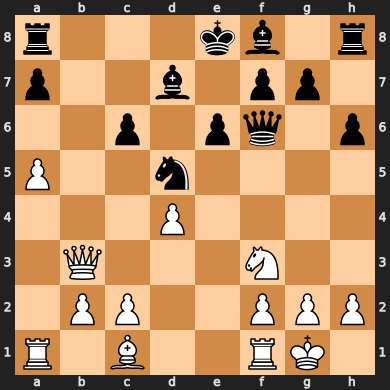

In [17]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_vector_with_state(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [18]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.89      0.82      0.85      5000
           1       0.78      0.79      0.79      7016
           2       0.82      0.75      0.78     14276
           3       0.92      0.95      0.93     57569
           4       0.80      0.76      0.78      7776
           5       0.80      0.77      0.78      4864
           6       0.87      0.81      0.84      3499

    accuracy                           0.88    100000
   macro avg       0.84      0.81      0.82    100000
weighted avg       0.88      0.88      0.88    100000



In [19]:
import json
import time

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = "experiments/logs"):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "input_dim": hyperparams.get("input_shape", "unknown"),
            "output_dim": hyperparams.get("output_shape", "unknown"),
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")


In [20]:
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = "experiments/logs"):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [21]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = "experiments/results"):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)

In [22]:
RUN_ID = "run_2025_12_28_giraffe_baseline_with_dropout_with_state"

hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "Adam",
    "input_shape": 774,
    "output_shape": 7
}

dataset_paths = {
    "train": "./dataset_processed/chess_state_bitboard_train.npz",
    "val":   "./dataset_processed/chess_state_bitboard_val.npz",
    "test":  "./dataset_processed/chess_state_bitboard_test.npz"
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/run_2025_12_28_giraffe_baseline_with_dropout_with_state_config.json
[Logs] Saved training history to experiments/logs/run_2025_12_28_giraffe_baseline_with_dropout_with_state_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        87.66%
[Results] Off-by-1 Acc:    98.48%
[Results] MAE:             0.1456
[Results] Latency:         0.0101 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 438 samples
   - Off by 4: 53 samples
   - Off by 5: 27 samples
   - Off by 6: 19 samples
[Results] Saved all metrics to experiments/results
------------------------------------------------------------


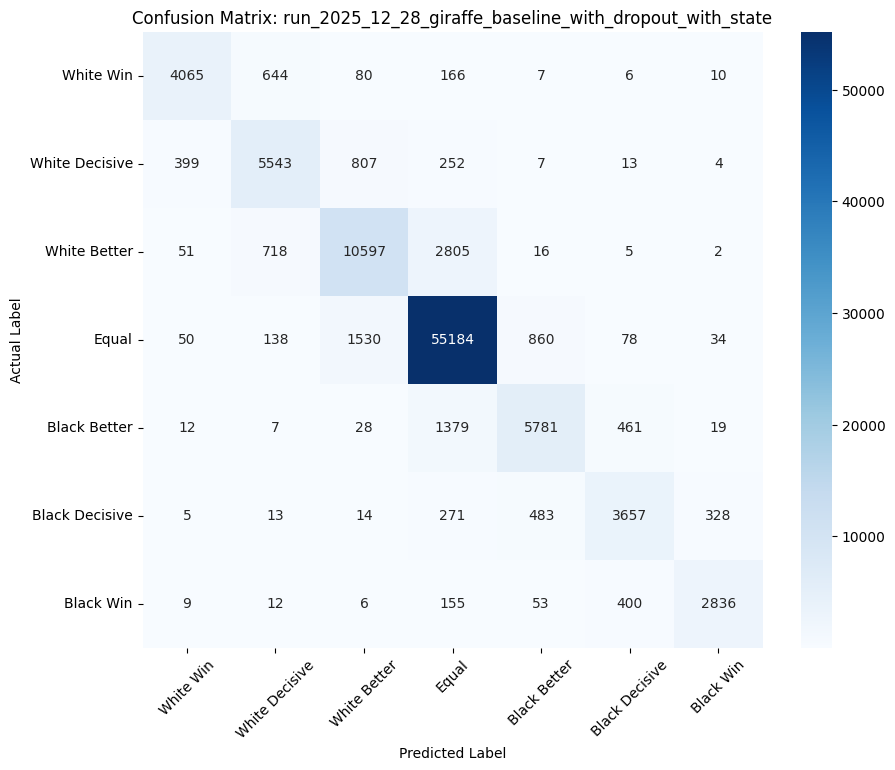

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(experiment_name: str, save_dir: str = "experiments/results"):
    matrix_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    try:
        cm = np.load(matrix_path)
    except FileNotFoundError:
        print(f"Could not find matrix at {matrix_path}")
        return

    class_names = [
        "White Win", "White Decisive", "White Better", "Equal", 
        "Black Better", "Black Decisive", "Black Win"
    ]

    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title(f"Confusion Matrix: {experiment_name}")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.show()

plot_confusion_matrix(RUN_ID)